In [28]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from HMC import HMC

tf.random.set_seed(1234)

# Pre-training and setup
## Creating a dummy model

Our model is a basic 4x1 Dense layer, without activation and with $L_1$ regularization. It uses the MSE loss.

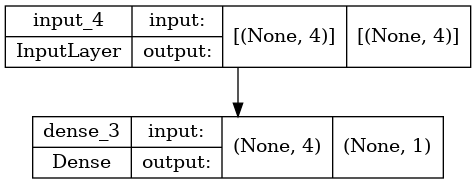

In [29]:
model = keras.Sequential([
    keras.Input(shape=(4,)),
    keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.L1(0.1), use_bias=False)
])
model.compile(optimizer=keras.optimizers.Adam(1e-2),
              loss=keras.losses.MeanSquaredError())
keras.utils.plot_model(model, show_shapes=True, to_file="../etc/test.png")

## Data

We create a trivial training set, with a regular grid $t$ sampled on $[-\pi, \pi]$. We set
- $x = (t^2, t, \cos(t), - t^3)$
- $y = t$
Thus we except our model to only use the 2nd coordinate of $x$ for its prediction.

In [30]:
# creating fake data
t = np.linspace(-3.14, 3.14, 50)
x = np.stack([
    t ** 2,
    t,
    np.cos(t),
    - t ** 3
]).T + 0 * np.random.randn(50, 4)
y = np.expand_dims(t, axis=1)

## Model training

In [31]:
# model pre-training
model.fit(x, y, epochs=500, verbose=0)

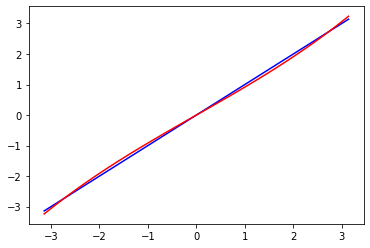

[<tf.Variable 'dense_3/kernel:0' shape=(4, 1) dtype=float32, numpy=
 array([[-6.9719710e-05],
        [ 9.0351576e-01],
        [-2.6005856e-04],
        [-1.2941720e-02]], dtype=float32)>]

In [32]:
# plot fitted prediction and model pre-trained parameters
fig = plt.figure()
plt.plot(t, y, 'b-')
plt.plot(t, model(x), 'r-')
plt.show()
model.trainable_variables

After 500 training step, we have a decent fit. Our parameters aren't set to $(0,1,0,0)$, but it should be good enough as a pre-training.

# HMC
## HMC walk

We now use the new `HMC` super-model to train our model, and predict uncertainties. It runs in about 20 seconds on my setup (GTX 1660 Ti).

In [33]:
# Create HMC super-model
hmc = HMC(model, L=10, epsilon=1e-2 , batch_size=50)

# Initialize bookkeeping
n_iter = 2000
parameters = np.zeros((n_iter, hmc.param_num), dtype=np.float32)  # bookkeeping the parameters
log_gamma = np.zeros((n_iter,), dtype=np.float32)  # bookkeeping the loggamma
log_lambda = np.zeros((n_iter,), dtype=np.float32)  # bookkeeping the loggamma
log_likelihood = np.zeros((n_iter,), dtype=np.float32)  # bookkeeping the loggamma
hamiltonians = np.zeros((n_iter,), dtype=np.float32)
acceptance = np.zeros((n_iter,), dtype=np.float32)

# training loop
for step in range(n_iter):
    new_state, loss, p, accepted, h = hmc((x, y))
    # print(f"Step {step}: ")
    if accepted:
        acceptance[step] = 1
        # print(f"New state accepted with probability {p}")
    # else:
    # print(f"New state rejected with probability {p}")

    # bookkeeping
    parameters[step, :] = new_state.position
    log_gamma[step] = new_state.log_gamma
    log_lambda[step] = new_state.log_lambda
    log_likelihood[step] = loss
    hamiltonians[step] = h

## HMC estimates and uncertainties

We compute these estimates the same way it was done in previous works

In [34]:
# Computing MAP estimate
idx_MAP = np.argmin(log_likelihood)
MAP = parameters[idx_MAP, :]
hmc.set_model_params(MAP)
y_MAP = hmc.model(x)

# preparing sampling
precision = np.exp(log_gamma)
num_dim = 1
n_samples = 1000
trajectories = np.zeros((50, num_dim, n_samples))
sigma_normal = np.std(y)

# sampling
for k in range(n_samples):
    idx_1 = np.random.randint(0, n_iter - 1)
    idx_2 = np.random.randint(0, n_iter - 1)
    w_sample = parameters[-idx_1, :]
    precision_here = precision[-idx_2] * num_dim
    hmc.set_model_params(w_sample)
    trajectories[:, :, k] = hmc.model(x) + sigma_normal * np.random.normal() / np.sqrt(precision_here)

mu_pred = np.mean(trajectories, axis=2)
sigma_pred = np.var(trajectories, axis=2)

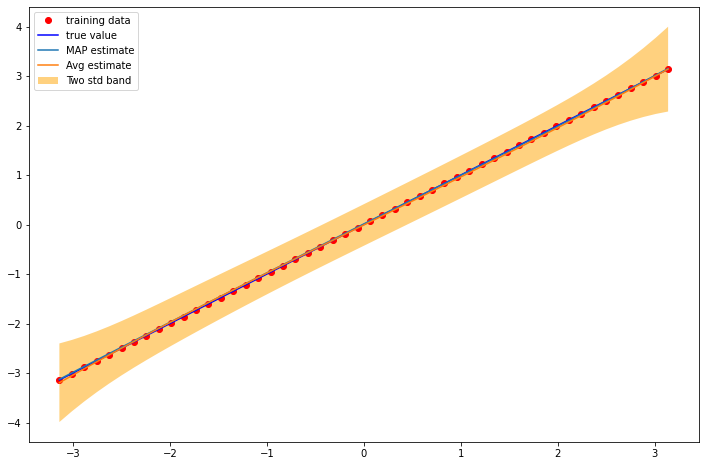

array([ 0.00266154,  0.98321503,  0.01268527, -0.00171743], dtype=float32)

In [35]:
# plot results and display MAP parameters
plt.figure(figsize=(12, 8))
plt.plot(t, y, 'ro', label="training data")
plt.plot(t, y, 'b-', label="true value")
plt.plot(t, y_MAP, label="MAP estimate")
plt.plot(t, mu_pred, label="Avg estimate")
lower = mu_pred[:, 0] - 2 * np.sqrt(sigma_pred[:, 0])
upper = mu_pred[:, 0] + 2 * np.sqrt(sigma_pred[:, 0])
plt.fill_between(t, lower, upper, facecolor="orange", alpha=0.5, label="Two std band")
plt.legend()
plt.show()
MAP

This result shows high uncertainty despite the simplicity of the model. The MAP estimate is also a worse fit than the pre-training. This could be linked to $t^3$ and $t$ being close, but on the range -3:3 it is unlikely to be the only issue.

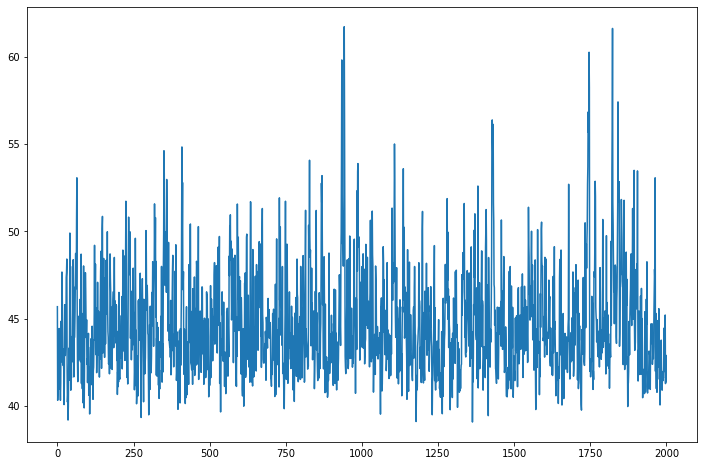

In [36]:
# Plot Hamiltonian variation through trajectory (should show any trend in theory)
plt.figure(figsize=(12,8))
plt.plot(range(hamiltonians.size), hamiltonians)
plt.show()

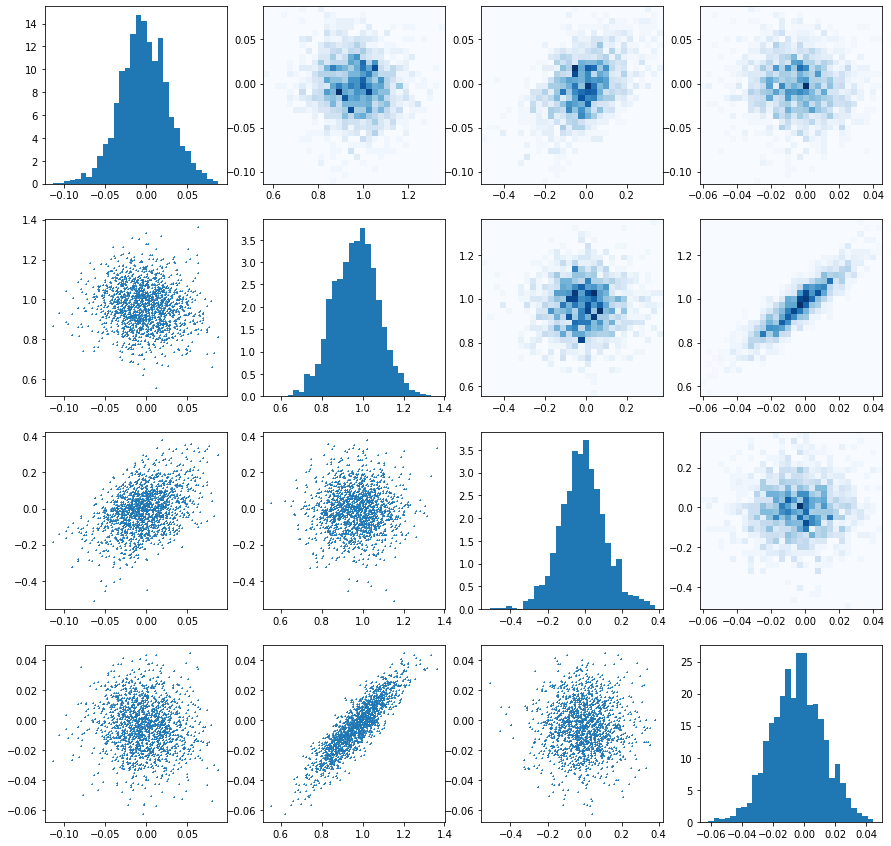

In [37]:
# plot parameters spread
fig, axs = plt.subplots(4, 4, figsize=(15, 15))
for i in range(4):
    axs[i, i].hist(parameters[:, i], bins=30, density=True)
    for j in range(i):
        axs[i, j].scatter(parameters[:, j], parameters[:, i], s=1, marker="+")
    for j in range(i + 1, 4):
        axs[i, j].hist2d(parameters[:, j], parameters[:, i], bins=30, cmap="Blues")
plt.show()


The parameters seem to be spread according to gaussian distributions, which is expected. But they seem to be too widely spread. Also, there is a high correlation between $t$ and $-t^3$ coefficients, which is expected.